In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

#-----
from torch.utils.tensorboard import SummaryWriter


#%matplotlib notebook
plt.style.use('seaborn')

## Loading dataset

In [21]:
class Propagator_Dataset(Dataset):
    
    def __init__(self, data, targets, total_data = 198000, transform=True):
        
        self.data = data
        self.targets = targets
        self.transform = transform
        self.total_data = total_data
        
    def __getitem__(self, index):
        
        total_data = self.total_data  # 198 data by file, 1000 files(from 0 to 999), total data: 198*100 = 19800
        
        if index > total_data:
            print("Error, this data does not exist")
        else:
            index_data = (index//199)%199  # because there 198 data per file
            index_t = (index-199)%199
            
            # Input data: Wavepacket real and imaginary part + Potential at time t
            x_r = (np.load(self.data+str(index_data)+'/Wavepacket/'+str(index_t)+'-wave.npy')).real
            x_i = (np.load(self.data+str(index_data)+'/Wavepacket/'+str(index_t)+'-wave.npy')).imag
            x_p = np.load(self.data+str(index_data)+'/Potential/'+str(index_t)+'-potential.npy')
            # Output data: Wavepacket real and imaginary part at time t+1*step
            y_r = (np.load(self.targets+str(index_data)+'/Wavepacket/'+str(index_t+1)+'-wave.npy')).real
            y_i = (np.load(self.targets+str(index_data)+'/Wavepacket/'+str(index_t+1)+'-wave.npy')).imag
        
            x = np.concatenate((x_r, x_i, x_p))  # flat array form

            y = np.concatenate((y_r, y_i))  # flat array form
        
            if self.transform:
                x = torch.from_numpy(x)
                y = torch.from_numpy(y)
        
            return x, y
    
    def __len__(self):
        
        
        return self.total_data



In [87]:
path = '../../Data_Gaussian/data'  # Directory where are saving our data

dataset = Propagator_Dataset(data=path, targets=path, transform=True)
batch_size = 36
validation_split = .1  #9:1 ratio
shuffle_dataset = True
random_seed= 42

In [88]:
dataset_size = len(dataset)
print('Total of data ', dataset_size)

Total of data  198000


In [89]:
# Creating data indices for training and validation splits:
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(val_indices)


In [90]:
print(f"Total of train samples: {len(train_sampler)}")
print(f"Total of test samples: {len(test_sampler)}")

Total of train samples: 178200
Total of test samples: 19800


In [91]:
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

## Visualization of data and shape

In [92]:
for X, y in train_loader:
    print("Train data:")
    print(f"Shape of X in train loader: {X.shape}")
    print(f"Shape of y in train loader: {y.shape} {y.dtype}")
    break
    
for X, y in test_loader:
    print("\nTest data:")
    print(f"Shape of X in test loader: {X.shape}")
    print(f"Shape of y in test loader: {y.shape} {y.dtype}")
    break
    
    

Train data:
Shape of X in train loader: torch.Size([36, 96])
Shape of y in train loader: torch.Size([36, 64]) torch.float64

Test data:
Shape of X in test loader: torch.Size([36, 96])
Shape of y in test loader: torch.Size([36, 64]) torch.float64


In [93]:
for X, y in train_loader:
    
    for i in range(batch_size):
        print(f"batch: {i} parte real\n {X[i,0:32]}")
        print(f"batch: {i}pparte imag\n {X[i,32:64]}")
        print("-------------------------------------------\n")
        
    break
    

batch: 0 parte real
 tensor([ 4.9862e-07,  9.6355e-04, -2.1288e-03,  3.6774e-03, -5.6735e-03,
         5.8585e-03, -1.2732e-02,  2.0504e-02, -1.6905e-02, -2.5976e-02,
        -1.4181e-01, -9.7909e-02, -8.8491e-02, -3.6956e-02, -4.4121e-01,
        -4.9339e-01, -4.4605e-01,  1.2909e-01,  2.8696e-01, -7.9046e-02,
        -4.3403e-01,  2.2145e-01,  5.1366e-02,  6.1022e-02, -1.1390e-01,
         2.0527e-02,  3.4772e-03,  5.5859e-03, -9.2664e-03,  3.9572e-03,
        -2.7651e-03, -7.8627e-09], dtype=torch.float64)
batch: 0pparte imag
 tensor([-9.9427e-07,  4.3913e-04, -9.3889e-04,  1.8056e-03, -2.0030e-03,
         3.5126e-03, -9.3135e-03, -2.1547e-03, -1.0905e-02, -4.4517e-03,
         3.2930e-02,  1.9467e-01,  1.4616e-01,  8.0763e-01,  1.0664e+00,
         9.7215e-01,  7.9962e-01,  5.9020e-01,  5.3786e-01,  4.8828e-01,
        -3.5162e-02, -2.5791e-01, -2.6977e-02,  2.1705e-01,  1.1654e-02,
        -2.4017e-02, -3.3147e-02, -4.3031e-03, -4.0663e-03,  1.9456e-03,
        -1.4118e-03,  1.07

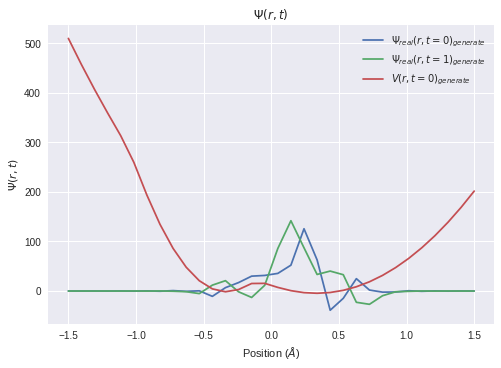

In [94]:
# Choose a random data
for X, y in train_loader:
    
    X_real_vis = X[0,0:32]
    X_imag_vis = X[0,32:64]
    X_pot_vis = X[0,64:96]
    
    y_real_vis = y[0,0:32]
    y_imag_vis = y[0,32:64]
    break
    
X_real_vis = X_real_vis.numpy()
y_real_vis = y_real_vis.numpy()
pot = X_pot_vis.numpy()
    
r_n = np.linspace(-1.5,1.5,32)
fig, ax = plt.subplots()
ax.set_title(r"$\Psi(r,t)$")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('$\Psi(r,t)$')

# Lenght: au -> Angstroms
ax.plot(r_n, X_real_vis*100, label="$\Psi_{real}(r, t=0)_{generate}$")  #Escaled
ax.plot(r_n, y_real_vis*100, label="$\Psi_{real}(r, t=1)_{generate}$")  # Escaled
ax.plot(r_n, pot*(1/1.5936e-3), label="$V(r, t=0)_{generate}$")  # kcal/mol

ax.legend()
plt.show()
    

In [95]:
def S_overlap_prueba(Psi_true, Psi_ANN):
    """
    Input:
    Psi_true: Evolution of wavepacket from dataset test
    Psi_ANN: Evolution of wavepacket predicted with the model
    
    Output:
    S: Absolute magnitude
    angle: phase
    Characterizes the quality of the predictions. See equation (11) of Main article
    
    """
    S_tot = []
    angle_tot = []
    for j in range(batch_size):
        Psi_true_re = Psi_true[j,0:32]  # real part of wavepacket
        Psi_true_im = Psi_true[j,32:64]  # imaginary part of wavepacket
        Psi_t = torch.view_as_complex(torch.stack((Psi_true_re,Psi_true_im), -1))
    
    
        Psi_ANN_re = Psi_ANN[j,0:32]  # realpart of wavepacket predicted
        Psi_ANN_im = -Psi_ANN[j,32:64]  # imaginary part of wavepacket predicted (- because conjugate)
        Psi_A = torch.view_as_complex(torch.stack((Psi_ANN_re,Psi_ANN_im), -1))
        
        
        
        overlap = []
        for i in range(32):
            overlap.append(torch.tensor([Psi_A[i]*Psi_t[i]]))
        overl = torch.tensor(overlap)
        
        # Integrate over r (real integral + complex integral)
        # Simpson method in the grid r_n (angstroms -> au)
        r_n = np.linspace(-1.5,1.5,32)*(1/0.5291775)
        overl_real = overl.real.numpy()
        overl_imag = overl.imag.numpy()
    
        real_integ = integrate.simpson(overl_real, r_n)
        imag_integ = integrate.simpson(overl_imag, r_n)
    
        # Covert to phase and magnitude of the complex result
        S_tot.append(np.sqrt(real_integ**2 + imag_integ**2))
        angle_tot.append(np.arctan(imag_integ/real_integ))
        
    S = sum(S_tot)/batch_size
    angle = sum(angle_tot)/batch_size
    
    return S, angle
    
    

## Test of accuracy function
Two same vectors should give S=1 & and angle=0

In [96]:
for X, y in train_loader:
    S, angle = S_overlap_prueba(y,y)
    print(S)
    print(angle)
    break

1.0
6.961061822446732e-19


In [97]:
size1 = len(test_loader.dataset)  # total of data ?
size1

198000

In [98]:
num_batches1 = len(test_loader)  # 1650*12=19800 that is the total of samples in test data and 12 is the baths size
num_batches1

550

In [99]:
# Test over test loader
correct1 = 0
for X, y in test_loader:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
    X, y = X.to(device), y.to(device)
    S, angle = S_overlap(y, y)  # Accuracy by equation (11) Main Article       
    correct1 += S
correct1 /= num_batches1
print(f"Test Error: \n Accuracy: {(100*correct1):>0.1f}%\n")


Test Error: 
 Accuracy: 100.0%



## Multilayer Perceptron model

In [100]:
device = "cpu"
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(96, 1024),
            nn.ReLU(),
            nn.ReLU(),
            nn.ReLU(),
            nn.Linear(1024, 64)
        )
        
    def forward(self, x):
        return self.layers(x)

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=96, out_features=1024, bias=True)
    (1): ReLU()
    (2): ReLU()
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=64, bias=True)
  )
)


In [110]:
writer = SummaryWriter('./runs/MLP')  # To use tensorboard

## Loss function & Optimizer

In [101]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

## Accuracy function

In [102]:
def S_overlap(Psi_true, Psi_ANN):
    """
    Input:
    Psi_true: Evolution of wavepacket from dataset test
    Psi_ANN: Evolution of wavepacket predicted with the model
    
    Output:
    S: Absolute magnitude
    angle: phase
    Characterizes the quality of the predictions. See equation (11) of Main article
    
    """
    S_tot = []
    angle_tot = []
    for j in range(batch_size):
        Psi_true_re = Psi_true[j,0:32]  # real part of wavepacket
        Psi_true_im = Psi_true[j,32:64]  # imaginary part of wavepacket
        Psi_t = torch.view_as_complex(torch.stack((Psi_true_re,Psi_true_im), -1))
    
    
        Psi_ANN_re = Psi_ANN[j,0:32]  # realpart of wavepacket predicted
        Psi_ANN_im = -Psi_ANN[j,32:64]  # imaginary part of wavepacket predicted (- because conjugate)
        Psi_A = torch.view_as_complex(torch.stack((Psi_ANN_re,Psi_ANN_im), -1))
        
        
        
        overlap = []
        for i in range(32):
            overlap.append(torch.tensor([Psi_A[i]*Psi_t[i]]))
        overl = torch.tensor(overlap)
        
        # Integrate over r (real integral + complex integral)
        # Simpson method in the grid r_n (angstroms -> au)
        r_n = np.linspace(-1.5,1.5,32)*(1/0.5291775)
        overl_real = overl.real.numpy()
        overl_imag = overl.imag.numpy()
    
        real_integ = integrate.simpson(overl_real, r_n)
        imag_integ = integrate.simpson(overl_imag, r_n)
    
        # Covert to phase and magnitude of the complex result
        S_tot.append(np.sqrt(real_integ**2 + imag_integ**2))
        angle_tot.append(np.arctan(imag_integ/real_integ))
        
    S = sum(S_tot)/batch_size
    angle = sum(angle_tot)/batch_size
    
    return S, angle

## Train & Test Loop

In [103]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X.float())
        loss = loss_fn(pred, y.float())
        writer.add_scalar("Loss/train", loss, epoch)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [105]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correctS, correct_phase = 0, 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            S, angle = S_overlap(y, pred)  
            correctS += S
            correct_phase += angle
    test_loss /= num_batches
    correctS /= num_batches
    correct_phase /= num_batches
    writer.add_scalar('Accuracy Magnitude |S| /test', 100*correctS, epoch)  # Should be 100%
    writer.add_scalar('Accuracy phase /test', correct_phase, epoch)  # Should be 0
    

    print(f"Test Error: \n Accuracy Magnitude |S|: {(100*correctS):>0.1f}%")
    print(f"Test Error: \n Accuracy phase: {(correct_phase):>0.1f}\n")

In [107]:
epochs = 30
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print("Done!")
writer.flush()

Epoch 1
-------------------------------
loss: 0.094486  [    0/198000]
loss: 0.090735  [ 3600/198000]
loss: 0.091231  [ 7200/198000]
loss: 0.091337  [10800/198000]
loss: 0.092434  [14400/198000]
loss: 0.090690  [18000/198000]
loss: 0.091440  [21600/198000]
loss: 0.090838  [25200/198000]
loss: 0.091766  [28800/198000]
loss: 0.091763  [32400/198000]
loss: 0.091588  [36000/198000]
loss: 0.090273  [39600/198000]
loss: 0.090162  [43200/198000]
loss: 0.091533  [46800/198000]
loss: 0.090158  [50400/198000]
loss: 0.090819  [54000/198000]
loss: 0.092715  [57600/198000]
loss: 0.091178  [61200/198000]
loss: 0.091019  [64800/198000]
loss: 0.090561  [68400/198000]
loss: 0.090502  [72000/198000]
loss: 0.091417  [75600/198000]
loss: 0.092097  [79200/198000]
loss: 0.091528  [82800/198000]
loss: 0.090031  [86400/198000]
loss: 0.091595  [90000/198000]
loss: 0.090371  [93600/198000]
loss: 0.091675  [97200/198000]
loss: 0.091362  [100800/198000]
loss: 0.090338  [104400/198000]
loss: 0.090112  [108000/1980

loss: 0.087325  [162000/198000]
loss: 0.087409  [165600/198000]
loss: 0.087500  [169200/198000]
loss: 0.087043  [172800/198000]
loss: 0.087175  [176400/198000]
Test Error: 
 Accuracy Magnitude |S|: 3.4%
Test Error: 
 Accuracy phase: -0.1%

Epoch 6
-------------------------------
loss: 0.087274  [    0/198000]
loss: 0.086447  [ 3600/198000]
loss: 0.086038  [ 7200/198000]
loss: 0.087117  [10800/198000]
loss: 0.087130  [14400/198000]
loss: 0.087757  [18000/198000]
loss: 0.087418  [21600/198000]
loss: 0.088109  [25200/198000]
loss: 0.087363  [28800/198000]
loss: 0.088377  [32400/198000]
loss: 0.087299  [36000/198000]
loss: 0.086767  [39600/198000]
loss: 0.087305  [43200/198000]
loss: 0.088148  [46800/198000]
loss: 0.087183  [50400/198000]
loss: 0.087290  [54000/198000]
loss: 0.086644  [57600/198000]
loss: 0.086163  [61200/198000]
loss: 0.087713  [64800/198000]
loss: 0.086711  [68400/198000]
loss: 0.085961  [72000/198000]
loss: 0.087250  [75600/198000]
loss: 0.085629  [79200/198000]
loss: 0

loss: 0.085793  [133200/198000]
loss: 0.084849  [136800/198000]
loss: 0.085308  [140400/198000]
loss: 0.084413  [144000/198000]
loss: 0.084030  [147600/198000]
loss: 0.085283  [151200/198000]
loss: 0.085246  [154800/198000]
loss: 0.086390  [158400/198000]
loss: 0.083702  [162000/198000]
loss: 0.085102  [165600/198000]
loss: 0.085970  [169200/198000]
loss: 0.085260  [172800/198000]
loss: 0.085489  [176400/198000]
Test Error: 
 Accuracy Magnitude |S|: 4.0%
Test Error: 
 Accuracy phase: -0.1%

Epoch 11
-------------------------------
loss: 0.085248  [    0/198000]
loss: 0.085761  [ 3600/198000]
loss: 0.084017  [ 7200/198000]
loss: 0.084645  [10800/198000]
loss: 0.086834  [14400/198000]
loss: 0.084509  [18000/198000]
loss: 0.084525  [21600/198000]
loss: 0.085178  [25200/198000]
loss: 0.084378  [28800/198000]
loss: 0.083800  [32400/198000]
loss: 0.085658  [36000/198000]
loss: 0.082395  [39600/198000]
loss: 0.083928  [43200/198000]
loss: 0.085914  [46800/198000]
loss: 0.083364  [50400/198000

loss: 0.084771  [104400/198000]
loss: 0.082199  [108000/198000]
loss: 0.083889  [111600/198000]
loss: 0.083333  [115200/198000]
loss: 0.083316  [118800/198000]
loss: 0.082511  [122400/198000]
loss: 0.084580  [126000/198000]
loss: 0.082754  [129600/198000]
loss: 0.082464  [133200/198000]
loss: 0.084440  [136800/198000]
loss: 0.083486  [140400/198000]
loss: 0.084278  [144000/198000]
loss: 0.084726  [147600/198000]
loss: 0.084860  [151200/198000]
loss: 0.082805  [154800/198000]
loss: 0.082856  [158400/198000]
loss: 0.084195  [162000/198000]
loss: 0.082445  [165600/198000]
loss: 0.083413  [169200/198000]
loss: 0.083450  [172800/198000]
loss: 0.083031  [176400/198000]
Test Error: 
 Accuracy Magnitude |S|: 4.8%
Test Error: 
 Accuracy phase: -0.1%

Epoch 16
-------------------------------
loss: 0.083864  [    0/198000]
loss: 0.083855  [ 3600/198000]
loss: 0.082188  [ 7200/198000]
loss: 0.083936  [10800/198000]
loss: 0.082856  [14400/198000]
loss: 0.083800  [18000/198000]
loss: 0.084635  [2160

loss: 0.081243  [75600/198000]
loss: 0.080487  [79200/198000]
loss: 0.081037  [82800/198000]
loss: 0.081432  [86400/198000]
loss: 0.082109  [90000/198000]
loss: 0.081753  [93600/198000]
loss: 0.082933  [97200/198000]
loss: 0.082091  [100800/198000]
loss: 0.082381  [104400/198000]
loss: 0.083107  [108000/198000]
loss: 0.082646  [111600/198000]
loss: 0.081242  [115200/198000]
loss: 0.079942  [118800/198000]
loss: 0.081240  [122400/198000]
loss: 0.079878  [126000/198000]
loss: 0.081837  [129600/198000]
loss: 0.083449  [133200/198000]
loss: 0.082814  [136800/198000]
loss: 0.084852  [140400/198000]
loss: 0.082925  [144000/198000]
loss: 0.082176  [147600/198000]
loss: 0.082739  [151200/198000]
loss: 0.083707  [154800/198000]
loss: 0.082962  [158400/198000]
loss: 0.082827  [162000/198000]
loss: 0.079819  [165600/198000]
loss: 0.081990  [169200/198000]
loss: 0.080436  [172800/198000]
loss: 0.081674  [176400/198000]
Test Error: 
 Accuracy Magnitude |S|: 5.8%
Test Error: 
 Accuracy phase: -0.1%


loss: 0.080444  [46800/198000]
loss: 0.082286  [50400/198000]
loss: 0.080783  [54000/198000]
loss: 0.080452  [57600/198000]
loss: 0.080381  [61200/198000]
loss: 0.078468  [64800/198000]
loss: 0.077305  [68400/198000]
loss: 0.077976  [72000/198000]
loss: 0.082104  [75600/198000]
loss: 0.079496  [79200/198000]
loss: 0.081780  [82800/198000]
loss: 0.082248  [86400/198000]
loss: 0.079794  [90000/198000]
loss: 0.079070  [93600/198000]
loss: 0.082341  [97200/198000]
loss: 0.080839  [100800/198000]
loss: 0.082889  [104400/198000]
loss: 0.080052  [108000/198000]
loss: 0.079495  [111600/198000]
loss: 0.078624  [115200/198000]
loss: 0.082109  [118800/198000]
loss: 0.082376  [122400/198000]
loss: 0.082521  [126000/198000]
loss: 0.082061  [129600/198000]
loss: 0.080923  [133200/198000]
loss: 0.081498  [136800/198000]
loss: 0.078628  [140400/198000]
loss: 0.081268  [144000/198000]
loss: 0.079356  [147600/198000]
loss: 0.079937  [151200/198000]
loss: 0.079708  [154800/198000]
loss: 0.079862  [158400

loss: 0.080140  [18000/198000]
loss: 0.078317  [21600/198000]
loss: 0.081238  [25200/198000]
loss: 0.079434  [28800/198000]
loss: 0.077322  [32400/198000]
loss: 0.081750  [36000/198000]
loss: 0.081580  [39600/198000]
loss: 0.077529  [43200/198000]
loss: 0.081185  [46800/198000]
loss: 0.077687  [50400/198000]
loss: 0.079960  [54000/198000]
loss: 0.079853  [57600/198000]
loss: 0.082005  [61200/198000]
loss: 0.077750  [64800/198000]
loss: 0.078526  [68400/198000]
loss: 0.075843  [72000/198000]
loss: 0.080950  [75600/198000]
loss: 0.079700  [79200/198000]
loss: 0.079852  [82800/198000]
loss: 0.076706  [86400/198000]
loss: 0.080752  [90000/198000]
loss: 0.080651  [93600/198000]
loss: 0.079497  [97200/198000]
loss: 0.078928  [100800/198000]
loss: 0.078621  [104400/198000]
loss: 0.080725  [108000/198000]
loss: 0.079230  [111600/198000]
loss: 0.080912  [115200/198000]
loss: 0.082607  [118800/198000]
loss: 0.077197  [122400/198000]
loss: 0.079104  [126000/198000]
loss: 0.079382  [129600/198000]

In [60]:
#torch.save(model, './MLPmodel02.pth')

## Inference

In [80]:
# Nota : Crear datos nuevos gaussianos

X1 = np.load("../../Data_Gaussian_Test/data0/Wavepacket/10-wave.npy")
X1p = np.load("../../Data_Gaussian_Test/data0/Potential/10-potential.npy")

Y1 = np.load("../../Data_Gaussian_Test/data0/Wavepacket/11-wave.npy")


X1_t = np.concatenate((X1.real,X1.imag, X1p))
Y1_t = np.concatenate((Y1.real, Y1.imag))



In [113]:
writer.add_graph(model,torch.from_numpy(X1_t).float())

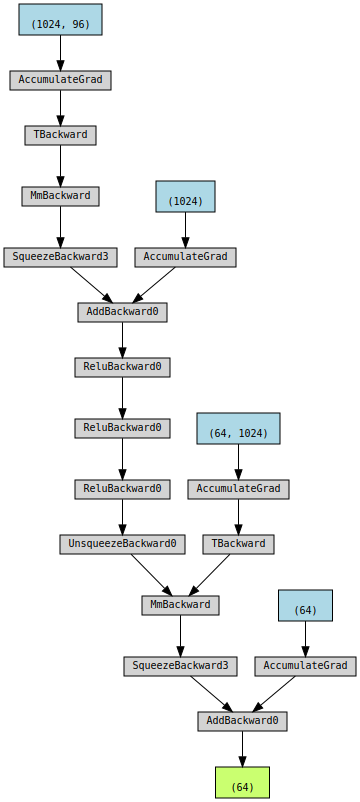

In [109]:
from torchviz import make_dot
out = model(torch.from_numpy(X1_t).float())
make_dot(out)

In [82]:
y1_pred = model(torch.from_numpy(X1_t).float())

In [83]:
y1_pred[0:32]

tensor([-0.0056,  0.0172,  0.0091, -0.0112,  0.0023,  0.0195,  0.0035, -0.0099,
        -0.0081,  0.0352,  0.0209,  0.0314,  0.0076, -0.0359, -0.0445, -0.1610,
        -0.2585, -0.3411, -0.2917, -0.0036,  0.2094,  0.2336,  0.1122,  0.0562,
         0.0162,  0.0264, -0.0260, -0.0270, -0.0019,  0.0219, -0.0126, -0.0049],
       grad_fn=<SliceBackward>)

In [84]:
y1_r = [-0.0056,  0.0172,  0.0091, -0.0112,  0.0023,  0.0195,  0.0035, -0.0099,
        -0.0081,  0.0352,  0.0209,  0.0314,  0.0076, -0.0359, -0.0445, -0.1610,
        -0.2585, -0.3411, -0.2917, -0.0036,  0.2094,  0.2336,  0.1122,  0.0562,
         0.0162,  0.0264, -0.0260, -0.0270, -0.0019,  0.0219, -0.0126, -0.0049]

In [85]:
y1_r = np.array(y1_r)

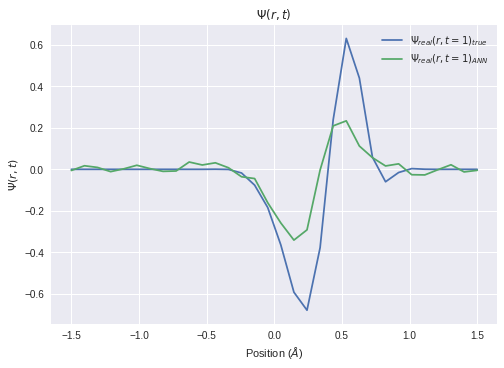

In [86]:
r_n = np.linspace(-1.5,1.5,32)
fig, ax = plt.subplots()
ax.set_title(r"$\Psi(r,t)$")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('$\Psi(r,t)$')

# Lenght: au -> Angstroms
#ax.plot(r_n, X1.real, label="$\Psi_{real}(r, t=0)_{generate}$")
ax.plot(r_n, Y1.real, label="$\Psi_{real}(r, t=1)_{true}$")

ax.plot(r_n, y1_r, label="$\Psi_{real}(r, t=1)_{ANN}$")

ax.legend()
plt.show()